With a new dataset, only modifying the following shall be sufficient. 
* Import Data
    * directory
    * file name
    * pd.read_csv() if different file type
    * data_name
    * label_name
* Prepare Data
    * In get_train_data function, modify the way binary labels are defined.
    * Number of posts (iterations) in get_word_data based on your interest
* Results
    * Modify the way 'keyword' is used based on your binary labels.

# Import Data

In [10]:
import pandas as pd
from tqdm import tqdm

In [11]:
directory = '/data1/link10/yelp/'
file_name = 'df1M.tsv'
raw_df = pd.read_csv(directory + file_name, delimiter = '\t')
# remove rows with missing values
df = raw_df.dropna()
df.head()

,review_id,stars,text
0,xQY8N_XvtGbearJ5X4QryQ,2,"As someone who has worked with many museums, I..."
1,UmFMZ8PyXZTY2QcwzsfQYA,1,I am actually horrified this place is still in...
2,LG2ZaYiOgpr2DK_90pYjNw,5,I love Deagan's. I do. I really do. The atmosp...
3,i6g_oA9Yf9Y31qt0wibXpw,1,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g..."
4,6TdNDKywdbjoTkizeMce8A,4,"Oh happy day, finally have a Canes near my cas..."


In [12]:
data_name = 'text'
label_name = 'stars'

In [13]:
print(
    'There are {} data.'.format(df.shape[0]),
    'Labels are: {}'.format(df[label_name].unique()),
    sep = '\n'
    )
df[label_name].value_counts()

There are 1000000 data.
Labels are: [2 1 5 4 3]


5    449091
4    210363
1    156690
3    104973
2     78883
Name: stars, dtype: int64

# Embedding

In [14]:
# !python -m spacy download en_core_web_lg
import numpy as np
import spacy

In [15]:
# # load the language model
# nlp = spacy.load('en_core_web_lg')

In [16]:
# with nlp.disable_pipes():
#     msg_vectors = np.array([nlp(msg.lower()).vector for msg in tqdm(df[data_name])])
# msg_vectors.shape

In [17]:
# yelp_glove_vectors = msg_vectors
# %store yelp_glove_vectors

In [18]:
# embedding takes huge amount of time, use stored result
%store -r yelp_glove_vectors
msg_vectors = yelp_glove_vectors
msg_vectors.shape

(1000000, 300)

# Play with data

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

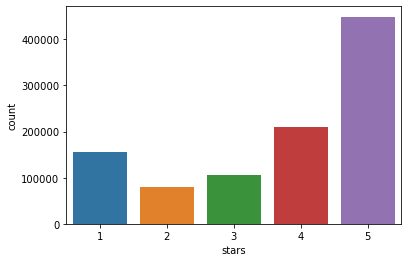

In [20]:
import seaborn as sb
import matplotlib.pyplot as plt
sb.countplot(x = label_name, data=df)

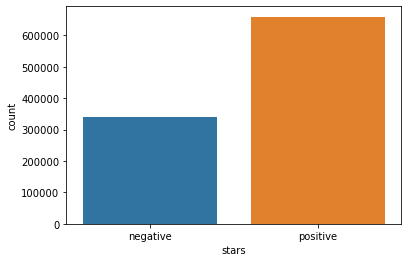

In [21]:
new_df = df.copy()
encode_map = {
    1: 'negative',
    2: 'negative',
    3: 'negative',
    4: 'positive',
    5: 'positive',
}
new_df[label_name].replace(encode_map, inplace=True)
sb.countplot(x = label_name, data=new_df)

In [22]:
# deal with class imbalance

In [23]:
# use partial data set for training
partial = 100000
keyword = 3

In [24]:
labels = np.array([1 if x > keyword else 0 for x in df[label_name]])
X_train, X_test, y_train, y_test = train_test_split(msg_vectors[0:partial], labels[0:partial],
                                                    test_size=0.2, random_state=1)

In [25]:
# # Standardize Input (skip for now)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [26]:
# X_train_ts = torch.from_numpy(X_train).type(torch.FloatTensor)
# Y_train_ts = torch.from_numpy(Y_train).type(torch.LongTensor)
# X_test_ts = torch.from_numpy(X_test).type(torch.FloatTensor)

# Set up Neural Network

In [27]:
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.001

In [28]:
## train data
class trainData(Dataset):    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))

In [29]:
## test data
class testData(Dataset):    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
test_data = testData(torch.FloatTensor(X_test))

In [30]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)#
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [31]:
# 2 layer Feed-Forward network with BatchNorm and Dropout
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()        # Number of input features is 12.
        self.layer_1 = nn.Linear(300, 1024) 
        self.layer_2 = nn.Linear(1024, 512)
        self.layer_3 = nn.Linear(512, 128)
        self.layer_out = nn.Linear(128, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
#         self.batchnorm1 = nn.BatchNorm1d(512)
#         self.batchnorm2 = nn.BatchNorm1d(512)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
#         x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
#         x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [32]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [33]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=300, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


# Train the model

In [34]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [35]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.33508 | Acc: 85.262
Epoch 002: | Loss: 0.29187 | Acc: 87.536
Epoch 003: | Loss: 0.28300 | Acc: 87.990
Epoch 004: | Loss: 0.27775 | Acc: 88.181
Epoch 005: | Loss: 0.27563 | Acc: 88.214
Epoch 006: | Loss: 0.27160 | Acc: 88.509
Epoch 007: | Loss: 0.26754 | Acc: 88.499
Epoch 008: | Loss: 0.26308 | Acc: 88.762
Epoch 009: | Loss: 0.26093 | Acc: 88.914
Epoch 010: | Loss: 0.25746 | Acc: 88.936


# Test the model

In [36]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [37]:
confusion_matrix(y_test, y_pred_list)

array([[ 5503,  1161],
       [ 1138, 12198]])

In [38]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      6664
           1       0.91      0.91      0.91     13336

    accuracy                           0.89     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.88      0.89      0.89     20000



# Results

In [39]:
# word_list, word_array, word_occr = get_word_data(nlp,df)

In [40]:
# yelp_glove_word = [word_list, word_array, word_occr]
# %store yelp_glove_word

In [41]:
# use stored result
%store -r yelp_glove_word
word_list = yelp_glove_word[0]
word_array = yelp_glove_word[1]
word_occr = yelp_glove_word[2]

In [42]:
## word data
class wordData(Dataset):    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
word_data = wordData(torch.FloatTensor(word_array))

In [43]:
word_loader = DataLoader(dataset=word_data, batch_size=1)

In [44]:
word_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in tqdm(word_loader):
        X_batch = X_batch.to(device)
        word_pred = model(X_batch)
        word_pred_list.append(word_pred.cpu().numpy())
word_pred_list = [a.squeeze().tolist() for a in word_pred_list]

100%|██████████| 321423/321423 [03:00<00:00, 1783.00it/s]


In [46]:
top_words = pd.DataFrame({'word':word_list,'prob':word_pred_list,'occurrence':word_occr})
top_words = top_words.sort_values('prob',ascending=False)

In [47]:
thresh = 1000
pos_words_f = top_words[top_words['occurrence']>thresh]

In [48]:
pos_words_f.head(15)

,word,prob,occurrence
5059,certified,69.262474,1010
14162,professionally,65.057510,1205
125,trained,61.979855,2532
2120,experienced,59.758179,8983
496,professional,57.151848,28889
4211,expert,52.674164,1930
3988,finest,47.928219,1035
3749,fully,46.041420,4934
4729,professionals,45.191513,1404
3210,technicians,44.697140,1561


In [49]:
neg_words_f  = pos_words_f.sort_values('prob',ascending=True)
neg_words_f.head(15)

,word,prob,occurrence
214,disgusting,-114.519264,6644
5805,unprofessional,-97.912903,6733
5349,tasteless,-97.151207,3938
9178,disrespectful,-93.768791,1535
9155,disgusted,-82.781464,1377
1367,unacceptable,-80.649254,2800
4447,filthy,-80.094994,2455
984,horrible,-79.794540,25833
5760,incompetent,-79.603256,1663
6959,miserable,-79.050980,1426
